<a href="https://colab.research.google.com/github/Mgrinet/image-recognition-inceptionV3/blob/master/Reconhecimento_de_Imagem_com_Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento de Imagem - Detecção de Gênero

O reconhecimento de imagem é uma das muitas aplicações do Machine Learning, ele pode resolver problemas para fins de segurança, detecção de objetos, detecção de rosto, saúde, entretenimento, entre outros. Esta aplicação tem um enorme potencial para ajudar a nossa sociedade, por isso é importante encontrar novos usos para esta ferramenta, melhorar os métodos atuais e obter insights mais precisos e úteis a partir dela. Um bom exemplo dessas aplicações é o trabalho feito pela pesquisa da Universidade Chinesa de Hong Kong para detecção de rosto usando aprendizado profundo (https://arxiv.org/abs/1509.06451).

Neste projeto, construiremos um Algoritmo de ML usando a CNN para prever a imagem se a pessoa for masculina ou feminina.


---

## Dataset

CelebA dataset (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)


### Conteudo

#### Sobre o Dataset

202.599 imagens de rosto de várias pessoas

10,177 identidades únicas, mas os nomes das identidades não são dados

40 anotações de atributos binários por imagem

5 locais de referência



### Importando as Bibliotecas

In [0]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [0]:
import tensorflow as tf
print(tf.__version__)

1.14.0


## Parte 1: Explorando os dados

Nós estaremos usando o Dataset CelebA, que inclui imagens de 178 x 218 px. Abaixo está um exemplo de como as imagens se parecem.

In [0]:
           
EXAMPLE_PIC = '/content/drive/My Drive/Colab Notebooks/Diogo/img_align_celeba/000001.jpg' # images_folder + 

TRAINING_SAMPLES = 621
VALIDATION_SAMPLES = 207
TEST_SAMPLES = 207
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

### Load the attributes of every picture
File: list_attr_celeba.csv

In [0]:
df_attr = pd.read_csv('list_attr_celeba2.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(1035, 40)

### Features disponiveis no dataset CelebA 

40 Features

In [0]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


### Visualizando uma imagem do dataset CelebA 
178 x 218 px

Smiling    1
Male       0
Young      1
Name: 000001.jpg, dtype: int64

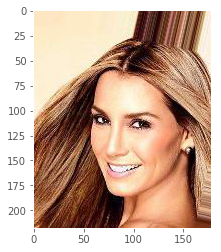

In [0]:
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']]

### Distribuição dos features

Há mais sexo feminino do que sexo masculino no conjunto de dados. Isso nos dá algumas dicas sobre a necessidade de equilibrar os dados nas próximas etapas.

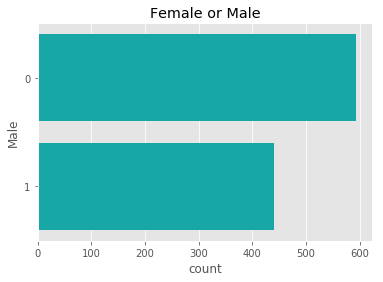

In [0]:
plt.title('Homem ou Mulher?')
sns.countplot(y='Homem', data=df_attr, color="c")
plt.show()

Etapa 2: Dividir o conjunto de dados em treinamento, validação e teste

O particionamento recomendado de imagens em treinamento, validação e teste do conjunto de dados é:

* 1-162770 estão treinando
* 162771-182637 são validação
* 182638-202599 estão testando

A partição está no arquivo <b>list_eval_partition.csv</b>

No devido tempo de execução, agora estaremos usando um número reduzido de imagens:

* Treinando 20.000 imagens
* Validação de 5000 imagens
* Teste 5000 Imagens

In [0]:
df_partition = pd.read_csv('list_eval_partition2.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [0]:
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    621
1    207
2    207
Name: partition, dtype: int64

#### Ingressar na partição e nos atributos no mesmo quadro de dados

In [0]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')

In [0]:
df_partition.shape

(1035, 1)

### 2.1: Gerar partições (treinamento, validação, teste)

O número de imagens precisa ser balanceado para obter um bom desempenho para o modelo, cada modelo terá sua própria pasta de treinamento, validação e teste de dados balanceados.


Nesta etapa, criaremos funções que nos ajudarão a criar cada partição.

In [0]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # Para treino e validacao
    if partition != 2:
        x_ = np.array([load_reshape_img(fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # para teste
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

## Etapa 3: Pré-processamento de imagens: auaugumentacao dos dados

A augumentacao de dados permite gerar imagens com modificações nas originais. O modelo aprenderá com essas variações (mudança de ângulo, tamanho e posição), podendo prever imagens melhores e nunca vistas, que podem ter as mesmas variações de posição, tamanho e posição.

3.1. Vamos começar com um exemplo: aumento de dados

É assim que uma imagem será exibida após o aumento dos dados (com base nos parâmetros de doação abaixo).

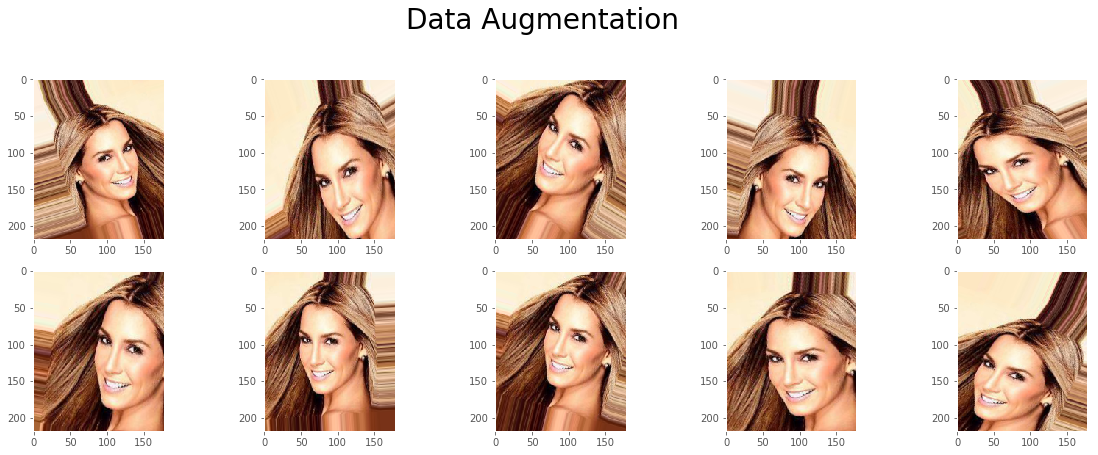

In [0]:
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

plt.figure(figsize=(20,10))
plt.suptitle('Augmentacao dos Dados', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

O resultado é um novo conjunto de imagens com modificações do original, que permite ao modelo aprender com essas variações para capturar esse tipo de imagem durante o processo de aprendizado e prever melhores imagens nunca vistas.

In [0]:
TRAINING_SAMPLES

621

###3.2. Construir Geradores de Dados

In [0]:
x_train, y_train = generate_df(0, 'Male', 20)

train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [0]:
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)


Com o gerador de dados criado e os dados para validação, estamos prontos para iniciar a modelagem.

### Etapa 4: Construir o modelo - reconhecimento de gênero

### 4.1. Defina o modelo

In [0]:
# Importar modelo InceptionV3 
inc_model = InceptionV3(weights='../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("Numero de camadas:", len(inc_model.layers))


<h2> Estrutura do Modelo Inception-V3 </h2>



<img src="https://i.imgur.com/kdXUzu1.png" width="1000px"/>


In [0]:
#Adicionar camadas customizadas
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

<h2>Novas Camadas</h2>
As camadas que vao ser treinadas com o novo dataset
<img src="https://i.imgur.com/rWF7bRY.png" width="800px"/>

In [0]:
 
model_ = Model(inputs=inc_model.input, outputs=predictions)


for layer in model_.layers[:52]:
    layer.trainable = False


model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

### 4.2. Treinar Modelo

In [0]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [0]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

#### O melhor modelo apos NUM_epech teve uma acuracia de validacao igual a 95.75%.

In [0]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

In [0]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

### 4.3. Avaliacao do Modelo

In [0]:
model_.load_weights('weights.best.inc.male.hdf5')

In [0]:
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Avaliacao do Modelo')
print('Acuracia de Teste: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

### 5. Conclusão

O modelo construído usando o aprendizado de transferência do InceptionV3 e adicionando camadas personalizadas reconhece com êxito o sexo, fornecendo uma imagem com <b> 94,8% de precisão sobre os dados de teste </b>. No entanto, existem algumas limitações detectadas e oportunidades para melhorias:

* Treine os algoritmos com todo o conjunto de dados de imagens. Devido à limitação de recursos computacionais, o modelo foi treinado com um subconjunto de imagens. Tendo uma máquina apropriada, o modelo pode ser treinado, incluindo todas as imagens. Isso fará com que o algoritmo aprenda em diferentes contextos da imagem, dando-lhe mais experiência para prever imagens melhores nunca vistas.

* Use estruturas de diferença para as CNNs. Essa abordagem pode oferecer melhor desempenho ao modelo, pois é uma tarefa dispendiosa, pois o modelo pode ser medido no conjunto de dados de teste após o treinamento e isso leva tempo e recursos computacionais.

* Observando as fotos do CelebA Data Set, a maioria das fotos é quase um close do rosto do sujeito, o que leva o modelo a aprender com esse tipo de foto e na situação em que os assuntos são apenas pequenos. parte de uma imagem, o modelo não teve um bom desempenho. Para lidar com isso, dados de pré-processamento mais sofisticados podem ser adicionados ou complementar o conjunto de dados com imagens que não são totalmente baseadas em close-up da face do sujeito.

* Os ambientes em que há mais de um assunto na imagem não faziam parte do escopo deste Notebook, mas é uma boa melhoria para desenvolver uma melhor aplicação. O OpenCV é um bom candidato para ajudar nesse desenvolvimento, pois é muito preciso detectar fezes e sua posição nas fotos; então, essa parte da imagem (as faces) pode ser classificada separadamente, usando os modelos desenvolvidos neste projeto.